In [6]:
import pandas as pd

# Загрузка данных
try:
    transactions = pd.read_parquet('transaction_fraud_data.parquet')
    exchange_rates = pd.read_parquet('historical_currency_exchange.parquet')
except FileNotFoundError:
    print("Убедитесь, что файлы 'transaction_fraud_data.parquet' и 'historical_currency_exchange.parquet' находятся в той же папке.")
    # Создадим пустые датафреймы для предотвращения ошибок ниже
    transactions = pd.DataFrame()
    exchange_rates = pd.DataFrame()

if not transactions.empty:
    # Преобразование формата для объединения
    transactions['date'] = pd.to_datetime(transactions['timestamp'].dt.date)
    exchange_rates['date'] = pd.to_datetime(exchange_rates['date'])

    # Подготовка таблицы с курсами для удобного объединения
    exchange_rates_long = exchange_rates.melt(
        id_vars=['date'], 
        var_name='currency', 
        value_name='rate_to_usd'
    )
    # Добавляем USD, курс которого всегда 1
    usd_rates = pd.DataFrame({
        'date': exchange_rates['date'],
        'currency': 'USD',
        'rate_to_usd': 1.0
    })
    exchange_rates_long = pd.concat([exchange_rates_long, usd_rates], ignore_index=True)

    # Объединение данных о транзакциях с курсами валют
    df = pd.merge(transactions, exchange_rates_long, on=['date', 'currency'], how='left')

    # Конвертация суммы в USD
    # Для валют, отсутствующих в справочнике, курс будет NaN, что мы заменим на 1 (без конвертации)
    df['rate_to_usd'].fillna(1, inplace=True)
    df['amount_usd'] = df['amount'] / df['rate_to_usd']
    
    print("Данные успешно загружены и объединены.")
    print(f"Размер итоговой таблицы: {df.shape}")
    print(df[['timestamp', 'amount', 'currency', 'amount_usd']].head())
    

Данные успешно загружены и объединены.
Размер итоговой таблицы: (7983826, 26)
                   timestamp     amount currency  amount_usd
0 2024-09-30 00:00:01.034820     294.87      GBP  394.658011
1 2024-09-30 00:00:01.764464    3368.97      BRL  619.905757
2 2024-09-30 00:00:02.273762  102582.38      JPY  719.506409
3 2024-09-30 00:00:02.297466     630.60      AUD  436.808287
4 2024-09-30 00:00:02.544063  724949.27      NGN  434.430069


/var/folders/xh/mw1w5hgd6m77043z9f2fy9sc0000gn/T/ipykernel_6001/127257743.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['rate_to_usd'].fillna(1, inplace=True)


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

if not transactions.empty:
    # 1. Разворачиваем вложенную структуру last_hour_activity
    last_hour_df = pd.json_normalize(df['last_hour_activity'])
    df = pd.concat([df, last_hour_df], axis=1)

    # 2. Создаем новый признак - час совершения транзакции
    df['hour_of_day'] = df['timestamp'].dt.hour

    # 3. Определяем признаки для модели (X) и целевую переменную (y)
    y = df['is_fraud']
    
    # Выбираем подмножество признаков для "легкой" модели
    features = [
        # Числовые признаки
        'amount_usd', 
        'num_transactions', 
        'total_amount', 
        'unique_merchants', 
        'unique_countries', 
        'max_single_amount',
        'hour_of_day',
        # Категориальные признаки
        'vendor_category', 
        'card_type', 
        'channel',
        # Бинарные признаки
        'is_card_present', 
        'is_outside_home_country', 
        'is_high_risk_vendor', 
        'is_weekend'
    ]
    X = df[features]

    # 4. Разделение данных на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.3, 
        random_state=42, 
        stratify=y  # Важно для несбалансированных данных
    )

    # 5. Создание пайплайна для предобработки данных
    # Определяем, какие колонки числовые, а какие категориальные
    numeric_features = X.select_dtypes(include=['int64', 'float64', 'int32']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Для бинарных признаков (boolean) не требуется специальная обработка,
    # но для чистоты пайплайна их можно пропустить через 'passthrough'
    boolean_features = X.select_dtypes(include=['bool']).columns.tolist()
    numeric_features = list(set(numeric_features) - set(boolean_features))


    # Создаем трансформеры
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    # Собираем все в ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            ('bool', 'passthrough', boolean_features) 
        ])
    
    print("Данные готовы для обучения модели.")

Данные готовы для обучения модели.


--- Отчет по классификации ---
              precision    recall  f1-score   support

   Not Fraud       0.98      0.85      0.91   1935539
       Fraud       0.59      0.91      0.71    459609

    accuracy                           0.86   2395148
   macro avg       0.78      0.88      0.81   2395148
weighted avg       0.90      0.86      0.87   2395148

AUC-ROC Score: 0.9563


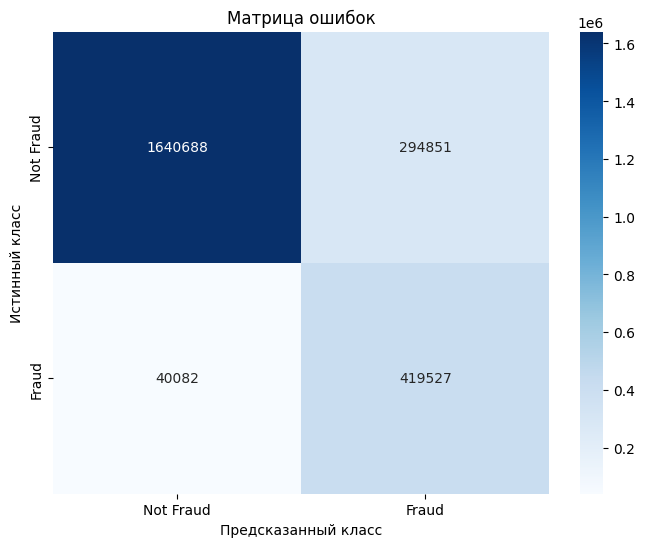

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

if not transactions.empty:
    # Создание итогового пайплайна с предобработкой и моделью
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000))
    ])

    # Обучение модели
    model_pipeline.fit(X_train, y_train)

    # Получение предсказаний
    y_pred = model_pipeline.predict(X_test)
    y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

    # Оценка качества модели
    print("--- Отчет по классификации ---")
    print(classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud']))

    auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f"AUC-ROC Score: {auc_score:.4f}")

    # Визуализация матрицы ошибок
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
    plt.title('Матрица ошибок')
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.show()